/home/julian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


UMPM


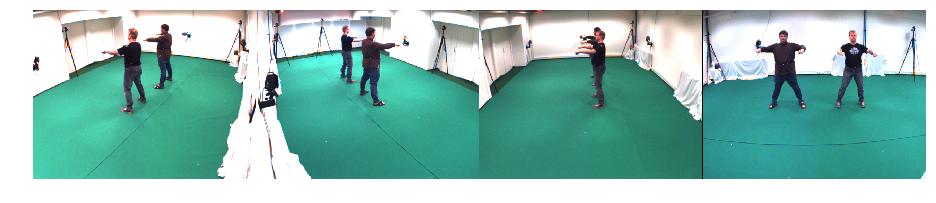

In [1]:
%matplotlib inline
# ---- settings ----
import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
sys.path.insert(0, '../'); sys.path.insert(0, '.')
import paf_loader
from os.path import join, isdir
import numpy as np

from mvpose.data import umpm

root = join(Settings['data_root'], 'pak')
user = Settings['UMPM']['username']
pwd = Settings['UMPM']['password']

# **************************** #
FRAME = 0
# **************************** #

X, Y, Calib = umpm.get(root, 'p2_free_1', user, pwd)

Im = np.array([X[0][FRAME], X[1][FRAME], X[2][FRAME], X[3][FRAME]])

heatmaps, pafs = paf_loader.load_confidence_map_and_paf('umpm', Im, FRAME)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111); ax.axis('off')
ax.imshow(np.hstack(Im))
plt.show()